### Шаг 1. Откройте файл с данными и изучите общую информацию. 

Импортируем, наеобходимые для работы, библиотеки

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import copy

In [2]:
flats = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
flats.info()

print(flats.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Открыли файл, с помощью, импортируемой библиотеки Pandas. Посмотрев на верхнюю часть таблицы методом head() увидели, что данные склеились в одном столбце, дописали аргумент sep = '\t' в строку считывания файла. С помощью просмотра названий столбцов <b> .columns </b> выяснили, что с ними всё в порядке, методом info() получили общую информацию о всей таблице. Узнали её размеры 23699х22, обнаружили много пропусков в разных атрибутах (при чём в разном количестве), floors_total (этажность дома), is_apartment(является апартаментами), balcony (число балконов), parks_around3000 (число парков), ponds_around3000(число водоёмов) и days_exposition (дни, сколько висело обьявление) имеют не соответствующие типы данных. Методом head() вызвав верхнушку таблицы, заметим, что locality_name содержит как верхний там и нижний регистр, с чем тоже могут быть проблемы.

### Шаг 2. Предобработка данных

Для начала на всякий случай приведём название городов locality_name в нижний регистр

In [3]:
flats['locality_name'] = flats['locality_name'].str.lower()

<h3> Обработка пропусков </h3>

Начнём с пропусков в атрибуте <b> is_apartmen </b>:

In [4]:
#Посмотрим на то, сколько столбцов принмают значения True и False
print(flats['is_apartment'].value_counts())
print('\n',' С пустым знаением "is_apartment" - {} строк'.format(flats['is_apartment'].isnull().sum()))

False    2725
True       50
Name: is_apartment, dtype: int64

  С пустым знаением "is_apartment" - 20924 строк


20924 пропущенных строк, посмотрим на них, если никаких закономерностей на глаз не определим, то предположим, что заместо Nan подразумевался 0 (False) и заполним пропуски этим значением.

In [3]:
#flats[flats['is_apartment'].isnull()].head()

In [6]:
flats['is_apartment'] = flats['is_apartment'].fillna(False)
print('После преобразований:','\n',flats['is_apartment'].value_counts())

После преобразований: 
 False    23649
True        50
Name: is_apartment, dtype: int64


Теперь заполним атрибут <b> balcony </b>. Возможно, пропущены также нулевые значения, проверим, сколько из строк с пропущенными балконами - квартиры на 1 этаже.

In [7]:
print(flats['balcony'].unique())
print('Квартир на первом этаже, с пропущенным количеством балконов:',len(flats.query('balcony.isnull() & floor == 1')))

[nan  2.  0.  1.  5.  4.  3.]
Квартир на первом этаже, с пропущенным количеством балконов: 1926


Всего лишь 1926... Ладно, предположим также, что пропущенное значение обозначет отсутствие балконов, следовательно, заменим на 0. Зато дополнительно узнали, что есть квартиры с 5-ю балконами, это исправим позже.

In [8]:
flats['balcony'] = flats['balcony'].fillna(0)

Посмотрим на пропуски в 'locality_name'

In [9]:
len(flats[flats['locality_name'].isnull()])

49

Их оказалось всего 49, удалим эти строки

In [10]:
flats.dropna(subset = ['locality_name'], inplace = True)
flats = flats.reset_index(drop = True)

Из данной таблицы могли бы пригодится расстояния до аэропорта и/или до центра, если не из нашей - то любые территориальные данные были бы полезны, например: адрес квартиры, содержащий улицу.

Пропуски в <b> parks_around3000 </b> и <b> ponds_around3000 </b>заполним также нулями, если у них также пропущены  parks_nearest и ponds_nearest соответственно, и установим 1 в тех случаях, где расстояние дано :

In [11]:
def completion_parks(row):
    parks_around3000 = row['parks_around3000']
    parks_nearest = row['parks_nearest']
    if (parks_around3000 != parks_around3000):
        if (parks_nearest != parks_nearest) | (parks_nearest > 3000):
            return 0
        else:
            return 1
    return parks_around3000

flats['parks_around3000'] = flats.apply(completion_parks, axis =1) 

In [12]:
def completion_ponds(row):
    ponds_around3000 = row['ponds_around3000']
    ponds_nearest = row['ponds_nearest']
    if (ponds_around3000 != ponds_around3000):
        if (ponds_nearest != ponds_nearest) | (ponds_nearest > 3000):
            return 0
        else:
            return 1
    return ponds_around3000
flats['ponds_around3000'] = flats.apply(completion_ponds, axis =1) 

In [13]:
def completion_fl_tot(row):
    floor = row['floor']
    ponds_around3000 = row['ponds_around3000']
    parks_around3000 = row['parks_around3000']
    floors_total = row['floors_total']
    locality_name = row['locality_name']
    total_area = row['total_area']
    if (floors_total != floors_total):
        datas = flats.loc[ (flats['locality_name'] == locality_name)
                     & (flats['parks_around3000'] == parks_around3000)
                     & (flats['ponds_around3000'] == ponds_around3000)
                     & (abs(total_area - flats['total_area']) <= 0.05 * flats['total_area']),:]
        floors_total = datas['floors_total'].median()
# Если пропуск ушёл, то на его место встанет вычисленное значение, а если нет, то сам этаж
    if (floors_total != floors_total):
        return floor
    else:
        return floors_total
flats['floors_total'] = flats.apply(completion_fl_tot, axis =1) 

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Заполним пропуски в площади кухни и жилой площади, а также в высоте потолков медианным значением по выборке, где это возможно, а где нет - просто медианным значением: 

In [14]:
def completion_kitch_ar(row):
    floors_total = row['floors_total']
    rooms = row['rooms']
    is_apartment = row['is_apartment']
    total_area = row['total_area']
    kitchen_area = row['kitchen_area']
    studio  = row['studio']
    if (kitchen_area != kitchen_area):
        datas = flats.loc[ (flats['is_apartment'] == is_apartment)
                     & (abs(total_area - flats['total_area']) <= 0.05 * flats['total_area'])
                     & (flats['studio'] == studio)
                     & (flats['rooms'] == rooms),:]
        kitchen_area = datas['kitchen_area'].median()
# Если пропуск ушёл, то на его место встанет вычисленное значение, а если нет, то медианное 
    if (kitchen_area != kitchen_area):
        return flats['kitchen_area'].median()
    else:
        return kitchen_area
flats['kitchen_area'] = flats.apply(completion_kitch_ar, axis =1) 

In [15]:
def completion_liv_ar(row):
    floors_total = row['floors_total']
    rooms = row['rooms']
    is_apartment = row['is_apartment']
    total_area = row['total_area']
    living_area = row['living_area']
    studio  = row['studio']
    if (living_area != living_area):
        datas = flats.loc[ (flats['is_apartment'] == is_apartment)
                     & (abs(total_area - flats['total_area']) <= 0.05 * flats['total_area'])
                     & (flats['studio'] == studio)
                     & (flats['rooms'] == rooms),:]
        living_area = datas['living_area'].median()
# Если пропуск ушёл, то на его место встанет вычисленное значение, а если нет, то медианное 
    if (living_area != living_area):
        return flats['living_area'].median()
    else:
        return living_area
flats['living_area'] = flats.apply(completion_liv_ar, axis =1) 

In [16]:
def completion_ceil_hei(row):
    floors_total = row['floors_total']
    rooms = row['rooms']
    is_apartment = row['is_apartment']
    total_area = row['total_area']
    living_area = row['living_area']
    studio  = row['studio']
    ceiling_height = row['ceiling_height']
    if (ceiling_height != ceiling_height):
        datas = flats.loc[ (flats['is_apartment'] == is_apartment)
                     & (abs(total_area - flats['total_area']) <= 0.05 * flats['total_area'])
                     & (flats['studio'] == studio)
                     & (flats['rooms'] == rooms),:]
        ceiling_height = datas['ceiling_height'].median()
# Если пропуск ушёл, то на его место встанет вычисленное значение, а если нет, то медианное 
    if (ceiling_height != ceiling_height):
        return flats['ceiling_height'].median()
    else:
        return ceiling_height
flats['ceiling_height'] = flats.apply(completion_ceil_hei, axis =1) 

Начнём заполнять пропуски в расстоянии до аэропорта и центра также заполним медианными значениями по выборке:

In [17]:
def completion_airpots_nearest(row):
    parks_around3000 = row['parks_around3000']
    ponds_around3000 = row['ponds_around3000']
    locality_name = row['locality_name']
    airports_nearest = row['airports_nearest']
    if (airports_nearest != airports_nearest):
        datas = flats.loc[ (flats['parks_around3000'] == parks_around3000)
                     & (flats['ponds_around3000'] == ponds_around3000)
                     & (flats['locality_name'] == locality_name),:]
        airports_nearest = datas['airports_nearest'].median()
# Если пропуск ушёл, то на его место встанет вычисленное значение, а если нет, то медианное по городу
    if (airports_nearest != airports_nearest):
        return flats[flats['locality_name']==locality_name]['airports_nearest'].median()
    else:
        return airports_nearest
flats['airports_nearest'] = flats.apply(completion_airpots_nearest, axis =1) 

In [18]:
def completion_cityCent_near(row):
    parks_around3000 = row['parks_around3000']
    ponds_around3000 = row['ponds_around3000']
    locality_name = row['locality_name']
    cityCenters_nearest = row['cityCenters_nearest']
    if (cityCenters_nearest != cityCenters_nearest):
        datas = flats.loc[ (flats['parks_around3000'] == parks_around3000)
                     & (flats['ponds_around3000'] == ponds_around3000)
                     & (flats['locality_name'] == locality_name),:]
        cityCenters_nearest = datas['cityCenters_nearest'].median()
# Если пропуск ушёл, то на его место встанет вычисленное значение, а если нет, то медианное по городу
    if (cityCenters_nearest != cityCenters_nearest):
        return flats[flats['locality_name']==locality_name]['cityCenters_nearest'].median()
    else:
        return cityCenters_nearest
flats['cityCenters_nearest'] = flats.apply(completion_cityCent_near, axis =1) 

In [19]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 22 columns):
total_images            23650 non-null int64
last_price              23650 non-null float64
total_area              23650 non-null float64
first_day_exposition    23650 non-null object
rooms                   23650 non-null int64
ceiling_height          23650 non-null float64
floors_total            23650 non-null float64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            23650 non-null bool
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            23650 non-null float64
balcony                 23650 non-null float64
locality_name           23650 non-null object
airports_nearest        18264 non-null float64
cityCenters_nearest     18264 non-null float64
parks_around3000        23650 non-null float64
parks_nearest           8064 non-null float64
ponds_around3000

Здесь этого оказалось недостаточным, такой результат говорит о существовании в базе квартир с уникальным названием города и/или пропусками в расстоянии во всём населённом пункте, проверим, в одних и тех же строках пропуски: для этого сравним количество строк с пропусками до аэропорта и количество строк с пропусками и до аэропорта и до центра:

In [20]:
len(flats[flats['airports_nearest']!=flats['airports_nearest']])

5386

In [21]:
len(flats[(flats['airports_nearest']!=flats['airports_nearest']) & (flats['cityCenters_nearest'] != flats['cityCenters_nearest'])])

5386

Их оказалось одинаковое количество, посмотрим на названия городов в этих строках:

In [22]:
flats[
    (flats['airports_nearest']!=flats['airports_nearest']) 
    & (flats['cityCenters_nearest'] != flats['cityCenters_nearest'])]['locality_name'].value_counts()

посёлок мурино                                             522
всеволожск                                                 398
гатчина                                                    307
деревня кудрово                                            299
выборг                                                     237
                                                          ... 
садоводческое некоммерческое товарищество лесная поляна      1
поселок городского типа кондратьево                          1
посёлок при железнодорожной станции приветнинское            1
деревня русско                                               1
поселок кирпичное                                            1
Name: locality_name, Length: 336, dtype: int64

Как и предполагалось, такими городами оказались маленькие города и посёлки с невыраженным центром и без аэропорта, заполним пропуски в расстоянии до центра города медианным).

In [23]:
#data['airports_nearest'] = data['airports_nearest'].fillna(100000)
flats['cityCenters_nearest'] = flats['cityCenters_nearest'].fillna(flats['cityCenters_nearest'].median())

Оставшиеся пропуски в расстоянии до парка или водоёма заполним аналогичным образом (медианным по выборке, где это вохзможно и просто медианным, где нет)

In [24]:
def completion_parks_nearest(row):
    parks_around3000 = row['parks_around3000']
    ponds_around3000 = row['ponds_around3000']
    parks_nearest = row['parks_nearest']
    locality_name = row['locality_name']
    if (parks_nearest != parks_nearest):
        datas = flats.loc[ (flats['parks_around3000'] == parks_around3000)
                     & (flats['ponds_around3000'] == ponds_around3000)
                     & (flats['locality_name'] == locality_name),:]
        parks_nearest = datas['parks_nearest'].median()
        
    if (parks_nearest != parks_nearest):
        return flats[flats['locality_name']==locality_name]['parks_nearest'].median()
    else:
        return parks_nearest
flats['parks_nearest'] = flats.apply(completion_parks_nearest, axis =1) 
flats['parks_nearest'] = flats['parks_nearest'].fillna(flats['parks_nearest'].median())

In [25]:
def completion_ponds_nearest(row):
    parks_around3000 = row['parks_around3000']
    ponds_around3000 = row['ponds_around3000']
    ponds_nearest = row['ponds_nearest']
    locality_name = row['locality_name']
    if (ponds_nearest != ponds_nearest):
        datas = flats.loc[ (flats['parks_around3000'] == parks_around3000)
                     & (flats['ponds_around3000'] == ponds_around3000)
                     & (flats['locality_name'] == locality_name),:]
        ponds_nearest = datas['ponds_nearest'].median()
        
    if (ponds_nearest != ponds_nearest):
        return flats[flats['locality_name']==locality_name]['parks_nearest'].median()
    else:
        return ponds_nearest
flats['ponds_nearest'] = flats.apply(completion_ponds_nearest, axis =1) 
flats['ponds_nearest'] = flats['ponds_nearest'].fillna(flats['ponds_nearest'].median())

Закончим заполнять пропуски, заполнив <b> days_exposition </b>. Посмотрим, возможно, они связаны с first_day_exposition: посмотрим на строки с этим пропуском:

Все пропуски были у значений, first_day_exposition которых был относительно недавно, скорее всего, эти квартиры ещё не были проданы, поэтому оставим пропуски для основного датасета и заменим их медианными значениями для копии датасета, чтобы потом сравнить результаты, после добавления в таблицу года и месяцев first_day_exposition проверим ещё раз нашу теорию

In [27]:
flats_without_days_expos = copy.deepcopy(flats)

In [28]:
flats_without_days_expos['days_exposition'] = (flats_without_days_expos['days_exposition']
                                               .fillna(flats_without_days_expos['days_exposition'].median()) )

Убедимся, что все пропуски заполнены, вызвав метод .info()

In [29]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 22 columns):
total_images            23650 non-null int64
last_price              23650 non-null float64
total_area              23650 non-null float64
first_day_exposition    23650 non-null object
rooms                   23650 non-null int64
ceiling_height          23650 non-null float64
floors_total            23650 non-null float64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            23650 non-null bool
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            23650 non-null float64
balcony                 23650 non-null float64
locality_name           23650 non-null object
airports_nearest        18264 non-null float64
cityCenters_nearest     23650 non-null float64
parks_around3000        23650 non-null float64
parks_nearest           23650 non-null float64
ponds_around300

<h2> Изменение типов данных </h2>

floors_total (этажность дома), is_apartment(является апартаментами), balcony (число балконов), parks_around3000 (число парков), ponds_around3000(число водоёмов), days_exposition (дни, сколько висело обьявление) и first_day_exposition (день публикации)  имеют не соответствующие типы данных. Исправим это.

Этажность дома, количество балконов, водоёмов и парков поблизости, а также число дней должны иметь целочисленный тип вместо вещественного

In [30]:
def changing_type(row):
    days_exposition = row['days_exposition']
    if (days_exposition == days_exposition):
        return int(days_exposition)
flats['days_exposition'] = flats.apply(changing_type, axis =1) 
# Функция почему-то не работает, аналоги с notna тоже :(

In [31]:
flats['ponds_around3000'] = flats['ponds_around3000'].astype('int')
flats['parks_around3000'] = flats['parks_around3000'].astype('int')
flats['balcony'] = flats['balcony'].astype('int')

По-сути булевское значение атрибута is_apartmen зачем-то имеет значение строки, это ресурсозатратно

In [32]:
flats['is_apartment'] = flats['is_apartment'].astype('bool')

Дата должна иметь тип datetime64

In [33]:
flats['first_day_exposition'] = flats['first_day_exposition'].astype('datetime64')

Все изменения мы проводили с помощью метода astype('type'), убедимся, что всё прошло гладко, вызвав информацию о данных методом info()

In [34]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 22 columns):
total_images            23650 non-null int64
last_price              23650 non-null float64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          23650 non-null float64
floors_total            23650 non-null float64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            23650 non-null bool
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            23650 non-null float64
balcony                 23650 non-null int64
locality_name           23650 non-null object
airports_nearest        18264 non-null float64
cityCenters_nearest     23650 non-null float64
parks_around3000        23650 non-null int64
parks_nearest           23650 non-null float64
ponds_aroun

<h3> Вывод: </h3>

Просмотрев информацию об открытом файле, мы узнали, что в нём много пропусков в разных атрибутах, а также много неверных типов данных. Пропуски преимущественно были заполненны медианными значениями по выборке, это занимает много времени, но зато даёт более точные данные, пропуски в количестве парков прудов или апартаментах были заполнены из логических соображений. Типы данных были изменены с вещественных на целочисленные (Этажность дома, количество балконов, водоёмов и парков), поскольку такими они и должны быть, дату публикации мы также заменили на соответствующий тип, также заменили is_apartment на булевский тип, поскольку он таковым и является.

### Шаг 3. Посчитайте и добавьте в таблицу

Посчитаем и добавим в таблицу цену квадратного метра:

In [35]:
def calculate_price_metre(row):
    last_price = row['last_price']
    total_area = row['total_area']
    return last_price / total_area
flats['price_one_metre'] = flats.apply(calculate_price_metre, axis =1)

Вычислим этаж относительно дома (первый, последний или другой):

In [36]:
def determine_floor(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
flats['relative_floor'] = flats.apply(determine_floor, axis =1)

Посчитаем отношение жилой и общей площади:

In [37]:
def relation_liv_total(row):
    living_area = row['living_area']
    total_area = row['total_area']
    return living_area /  total_area
flats['relation_liv_total'] = flats.apply(relation_liv_total, axis =1)

Посчитаем отношение площади кухни и общей площади:

In [38]:
def relation_kit_total(row):
    kitchen_area = row['kitchen_area']
    total_area = row['total_area']
    return kitchen_area /  total_area
flats['relation_kit_total'] = flats.apply(relation_kit_total, axis =1)

Добавим день недели, месяц и год публикации объявления:

In [39]:
flats['month_exposition'] = pd.DatetimeIndex(flats['first_day_exposition']).month
flats['year_exposition'] = pd.DatetimeIndex(flats['first_day_exposition']).year
flats['weekday_exposition'] = pd.DatetimeIndex(flats['first_day_exposition']).weekday

Убедимся в том, что всё прошло хорошо вызвав информацию о таблице:

In [40]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 29 columns):
total_images            23650 non-null int64
last_price              23650 non-null float64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          23650 non-null float64
floors_total            23650 non-null float64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            23650 non-null bool
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            23650 non-null float64
balcony                 23650 non-null int64
locality_name           23650 non-null object
airports_nearest        18264 non-null float64
cityCenters_nearest     23650 non-null float64
parks_around3000        23650 non-null int64
parks_nearest           23650 non-null float64
ponds_aroun

<h3>Вывод: </h3>

Мы расчитали цену квадратного метра, относительную этажность дома, отношение площадей кухни и жилой к общей, а также разбили дату публикации на составляющие, в виде месяца, года и дня недели. Всё это мы записали в отдельные столбцы, дополнив наш датафрейм.

<H3> Проверим пропуски в first_day_exposition:</H3>

In [41]:
# Создадим таблицу, в которой у всех days_exposition будет пропуск
passes = flats[ flats['days_exposition'].isnull()]

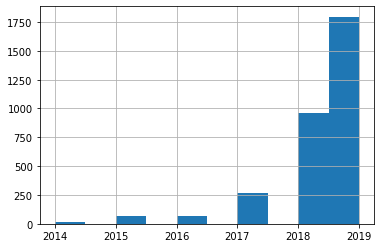

In [42]:
passes['year_exposition'].hist();

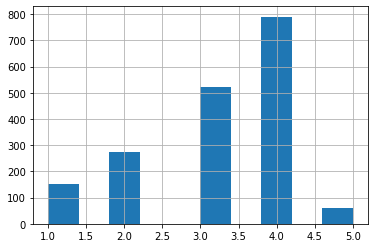

In [43]:
passes = passes[passes['year_exposition'] == 2019]
passes['month_exposition'].hist();

Мы были правы, когда сказали, что пропуски в days_exposition связаны с тем, что квартиры ещё находятся в продаже, гистограммы подтверждают наши слова, чем ближе к сегодня, тем пропущенных значений больше, данные взяты по видимому до мая 19го года

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

<h3> Изучение параметров </h3>

Изучим след. параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.

In [44]:
def histogram(data ,atribut):
    print('Основная информация об атрибуте "{}":'.format(atribut));
    print(flats[atribut].describe());
    plt.ylabel('Frequency')
    plt.xlabel(atribut)
    tit = 'Распределение по "{}":'.format(atribut)
    plt.title(tit)
    Q1 = data[atribut].describe()['25%']
    Q3 = data[atribut].describe()['75%']
    IQR = Q3 - Q1
    a = Q1-3*IQR
    b = Q3+3*IQR
    data[atribut].hist(bins=50, range=(a, b));

<b> Площадь: </b>

Основная информация об атрибуте "total_area":
count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64


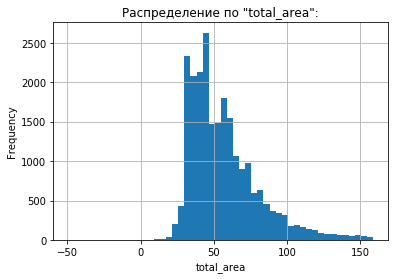

In [45]:
histogram(flats, 'total_area')

График имеет пик в районе средних значений (около 60) и длинный хвост, который будет доходить до 900м. Также принимает редкие значения до 25м.

<b>Цена:</b>

Основная информация об атрибуте "last_price":
count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64


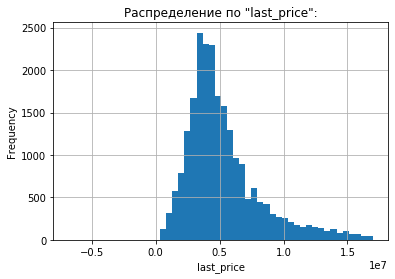

In [46]:
histogram(flats, 'last_price')

Пик распределения приходится на медианное значение, среднее значение сильно смещено вправо за счёт квартиры за 760 млг. Также имеются квартиры намного дешевле средней.

<b>Число комнат:</b>

Основная информация об атрибуте "rooms":
count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


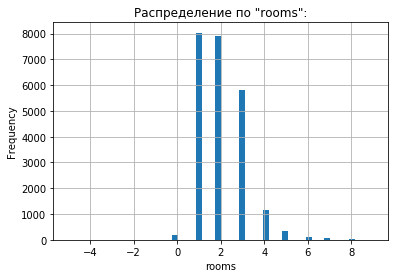

In [47]:
histogram(flats, 'rooms')

Заметно преобладание 1,2 и 3-комнатных квартир, но таккже встречаются и единичные случаи. доходящие до 19

<b>Высота потолков:</b>

Основная информация об атрибуте "ceiling_height":
count    23650.000000
mean         2.730584
std          0.993620
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64


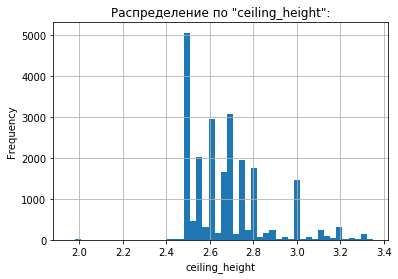

In [48]:
histogram(flats, 'ceiling_height')

Основная масса потолков имеет высоту 2.5-2.55,  по структуре графика можно сказать. что большая часть квартир имеет нормированную высоту потолков, также встречаются выбросы с одной и с другой стороны.

<b> Вывод:</b> площадь, цена, число комнат, высота потолков схожи между собой, все имеют пик в среднем значении, и убывающий хвост, имеют несколько выбивающихся значений минимума и одно сильно выбивающееся в максимуме.

<h3> Изучение времени продажи квартир </h3>

Гистограмма, если заполнять пропуски медианным значением:

Основная информация об атрибуте "days_exposition":
count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


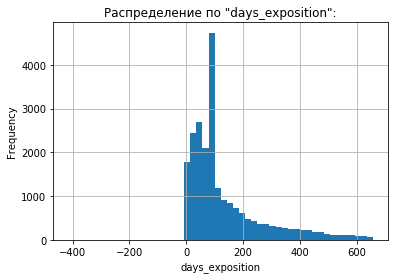

In [49]:
histogram(flats_without_days_expos, 'days_exposition');

Гистограмма, если оставлять пропуски

Основная информация об атрибуте "days_exposition":
count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


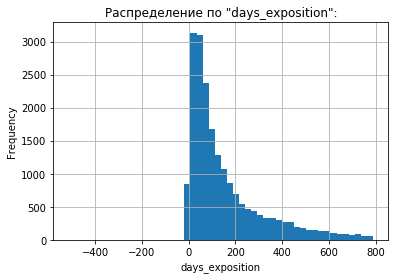

In [50]:
histogram(flats, 'days_exposition');

Посмотрим на гистограммы, в диапозоне до длинного хвоста:

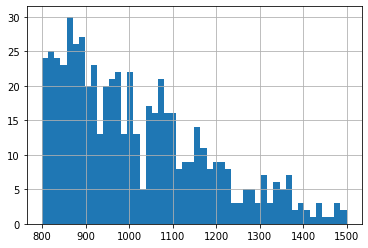

In [51]:
flats['days_exposition'].hist(range = (800,1500), bins = 50);

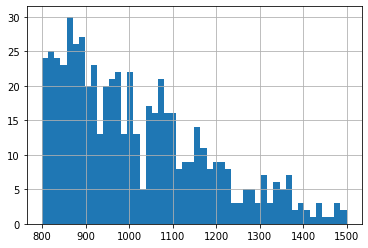

In [52]:
flats_without_days_expos['days_exposition'].hist(range = (800,1500), bins = 50);

Значения больше 800 не привышают больше 35 случаев.

<b>Вывод: </b>  обычно продажа занимает 170-210 дней, необычно долгими можно считать продажи, проходящие дольше 800 дней, необычно быстрые продажи - проходят меньше чем за месяц. Если пропуски заменять медианными, то будет большой пик на медианном значении, если же пропуски оставить, то среднее значение увеличится и пиковых значений будет больше, хотя сам пик и станет ниже.

<h3> Избавление от редких и выбивающихся значений </h3>

Изучая площадь, цену, число комнат и высоту потолков в задании выше мы столкнулись с выбивающимися значениями, избавимся от них: избавляться будем согласно правилу, что выбросом считаются все значения меньшие чем 1й квантиль на 1.5 квантильных размаха и больше чем 3й квантиль на 1.5 квантильных размаха:

In [53]:
def scope_quartile (data,atribut):
    per_cent_75 = data[atribut].describe()['75%']
    per_cent_25 = data[atribut].describe()['25%']
    return (per_cent_75 - per_cent_25)*3/2

In [54]:
def delete(data,atribut):
    plt.subplot(1, 2, 1)
    data[atribut].plot(figsize = (10,4), kind = 'box', grid = True, title ="Boxplot по '{}' до преобразований".format(atribut));
    per_cent_75 = data[atribut].describe()['75%']
    per_cent_25 = data[atribut].describe()['25%']
    scope = scope_quartile (data,atribut)
    new_data = data[(data[atribut] > per_cent_25 - scope)
               & (data[atribut] < per_cent_75 + scope)]
    plt.subplot(1, 2, 2)
    new_data[atribut].plot(kind = 'box', grid = True, title ="Boxplot по '{}' после преобразований".format(atribut));
    return new_data

<h3> Площадь </h3> 

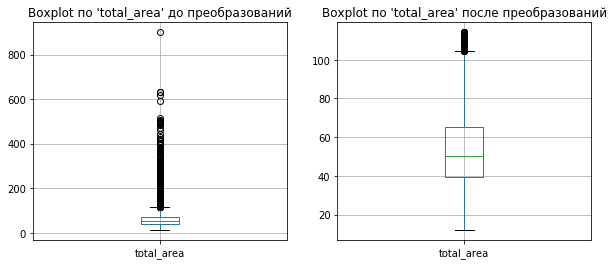

In [55]:
flats = delete(flats, 'total_area')

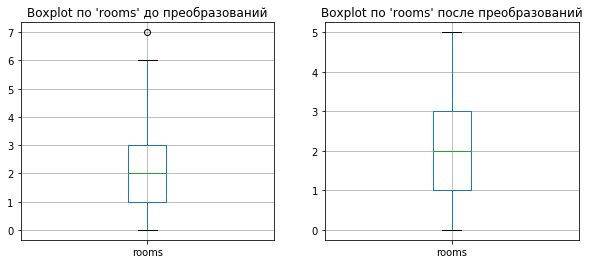

In [56]:
flats = delete(flats, 'rooms')

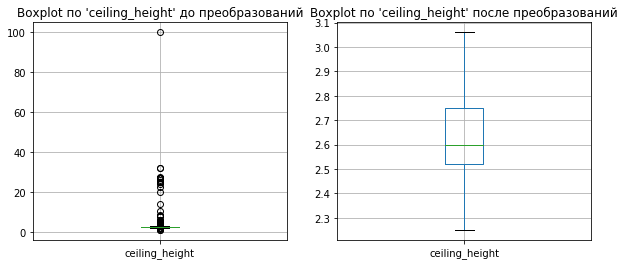

In [57]:
flats = delete(flats, 'ceiling_height')

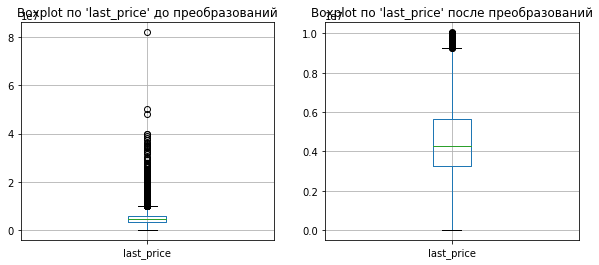

In [58]:
flats = delete(flats, 'last_price')

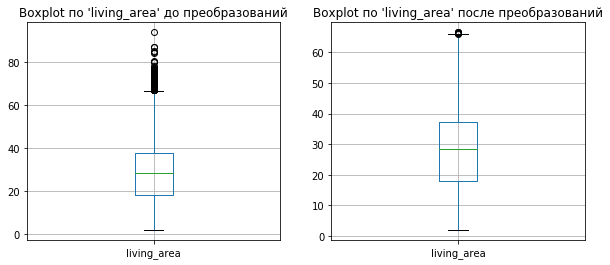

In [59]:
flats = delete(flats, 'living_area')

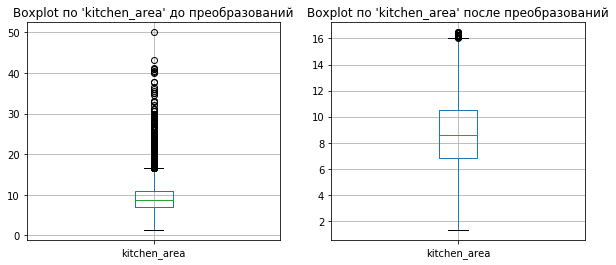

In [60]:
flats = delete(flats, 'kitchen_area')

<b> Вывод: </b> мы избавились от выбивающихся значений с помощью правила полуторного межквартильного размаха и визуализировали это с помощью ящиков с усами для каждого параметра.

<h3> Изучение зависимости цены от значения разных атрибутов </h3>

квадратного метра, числа комнат, удалённости от центра, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.

In [61]:
# Функция постраения графиков зависимости цены и цены кв.м. от различных параметров
def chart(data, atribut):
    pivot_tab = data.groupby(atribut)[['last_price']].median()
    pivot_tab_one_metre = data.groupby(atribut)[['price_one_metre']].median()
    pivot_tab.plot(grid = True, style = '.-');
    plt.xlabel(atribut)
    tit = 'Зависимость цены от "{}":'.format(atribut)
    plt.title(tit)
    
    pivot_tab_one_metre.plot(grid = True, style = '.-');
    plt.xlabel(atribut)
    tit = 'Зависимость цены кв.м. от "{}":'.format(atribut)
    plt.title(tit)

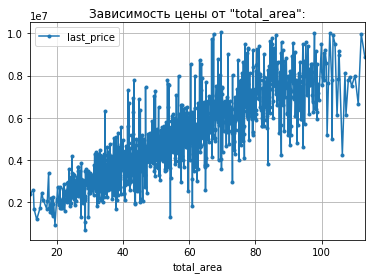

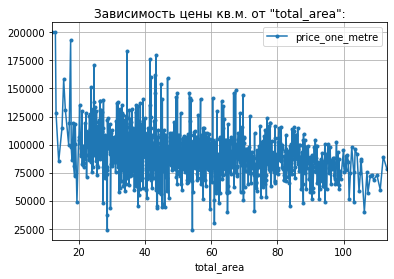

In [62]:
chart(flats, 'total_area')

Заметна корреляция между общей площадью и ценой, что не удивительно, после 120 метров встречаются единичные случаи каких-то артефактов, сильно меняющие график, наверное, какие-то затаившиесся ошибки.

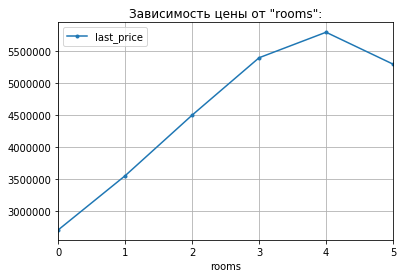

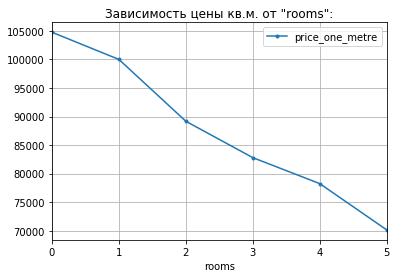

In [63]:
chart(flats, 'rooms')

Цена от количества комнат линейно увеличивается, в то время как цена кв.м. уменьшается, причём самый большой спад между одной и двумя комнатами.

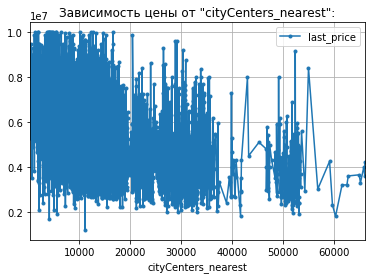

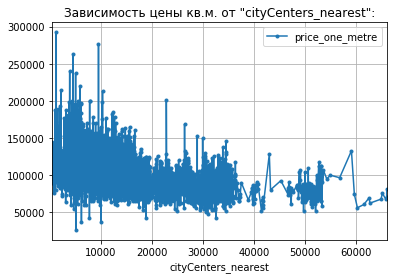

In [64]:
chart(flats, 'cityCenters_nearest')

Графики похожи: имеют большой разброс в цене на любом расстоянии, а также редеют по мере увеличения расстояния, у графика цены кв.м. заметен тренд падения цены по мере увеличения расстояния.

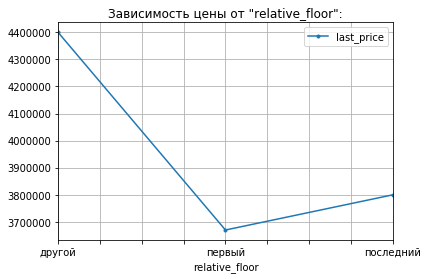

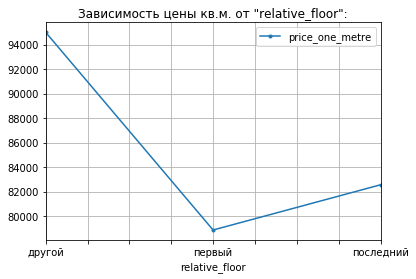

In [65]:
chart(flats,'relative_floor')

Здесь мы видим, что первый этаж ценится меньше чем последний, 1й и последний этажи ценятся много меньше чем любые другие.

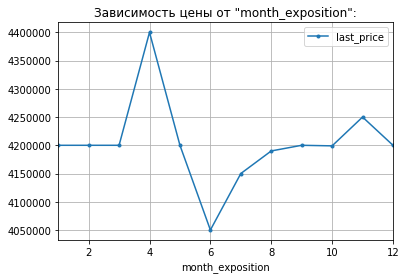

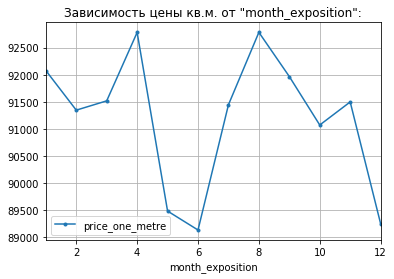

In [66]:
chart(flats,'month_exposition')

Самые дорогие квартиры продаются в апреле, а самые дешёвые в июне, в то время, как график цены кв.м. имеет 2 пика цены, в апреле и в августе, а минимум в декабре.

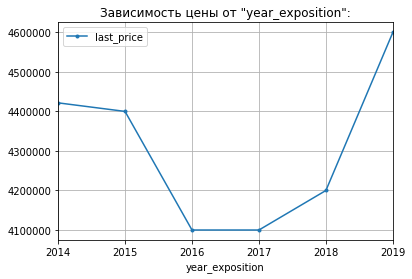

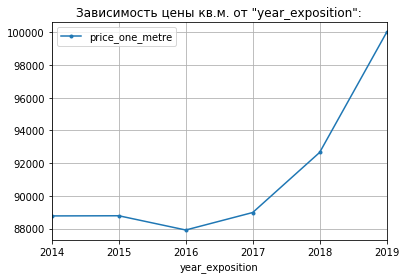

In [67]:
chart(flats,'year_exposition')

Цена квартир сильно падала с 2014-го по 2016-й, в 16-м стояла на месте и затем пошла вверх, в то время, как в среднем цена кв.м. почти не ощутила падения, немного подросла за период 2016-2017 года и повторила первый график в 2017-2019 гг.

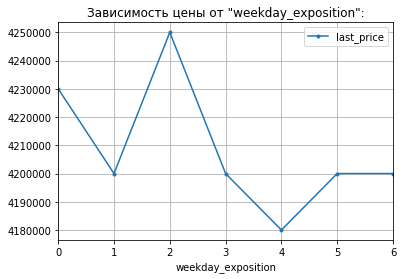

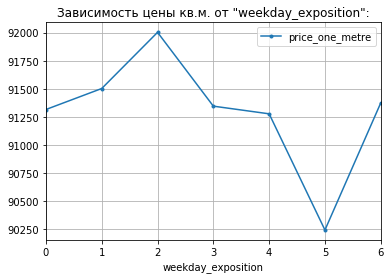

In [68]:
chart(flats,'weekday_exposition')

Самые дорогие квартиры продаются в понедельник-вторник, самые дешёвые в пятницу. Для цены кв. м. ситуация похожая, только смещена на день, самые дешёвые метры продаются в субботу, самые дорогие во вт.-ср.

Для численной оценки взаимосвязи параметров использую корреляции. Применим метод corr() к датафрейму, смотреть числовые значения будем по столбцу price_one_metre.

In [69]:
flats.corr()['price_one_metre'].sort_values()

rooms                 -0.272901
relation_liv_total    -0.251253
living_area           -0.228437
cityCenters_nearest   -0.171984
total_area            -0.150711
airports_nearest      -0.044479
days_exposition       -0.035176
weekday_exposition    -0.007268
month_exposition      -0.005956
is_apartment           0.014989
open_plan              0.023914
balcony                0.046051
studio                 0.051412
ponds_nearest          0.059355
year_exposition        0.076255
total_images           0.113106
parks_nearest          0.181654
kitchen_area           0.211683
ceiling_height         0.235193
parks_around3000       0.250925
ponds_around3000       0.261316
floor                  0.272757
relation_kit_total     0.325368
floors_total           0.382134
last_price             0.630757
price_one_metre        1.000000
Name: price_one_metre, dtype: float64

<b>Вывод: </b> наибольшую положительную зависимость цена кв.м. имеет от общей стоимости квартиры, этажности дома и этажа самой квартиры, а также от количества парков и водоёмов по близости и площади кухни (абсолютной и относительной), а отрицательную зависимость имеет от количества комнат, жилой плозади(абсолютной и относительной) и общей площади. Выглядит логично, чем больше квартира, тем меньше стоит средний её квадрат.

<h3> Анализ цены кв.м. в самых популярных городах </h3>

In [70]:
most_com_loc_name = flats['locality_name'].value_counts().head(10)

In [71]:
most_com_loc_name 

санкт-петербург      11921
посёлок мурино         502
посёлок шушары         425
всеволожск             377
колпино                313
посёлок парголово      311
пушкин                 306
гатчина                295
деревня кудрово        274
выборг                 208
Name: locality_name, dtype: int64

In [72]:
most_pop_local_list = ['санкт-петербург', 'посёлок мурино', 'посёлок шушары', 'всеволожск',
                            'пушкин','колпино','посёлок парголово','гатчина','деревня кудрово', 'выборг']
most_pop_local = flats.query('locality_name in @most_pop_local_list')
most_pop_local_piv_tab = most_pop_local.groupby('locality_name')[['price_one_metre']].median()

In [73]:
min = most_pop_local_piv_tab['price_one_metre'].min()
max = most_pop_local_piv_tab['price_one_metre'].max()
print ('Город с минимальной ценой за кв. м:',"\n" , most_pop_local_piv_tab.query('price_one_metre == @min'), "\n")
print ('Город с максимальной ценой за кв. м:',"\n" , most_pop_local_piv_tab.query('price_one_metre == @max'), "\n")
print('Отношение самой высокой цены к самой низкой - ',  max / min)

Город с минимальной ценой за кв. м: 
                price_one_metre
locality_name                 
выборг            57610.932188 

Город с максимальной ценой за кв. м: 
                  price_one_metre
locality_name                   
санкт-петербург    101136.363636 

Отношение самой высокой цены к самой низкой -  1.7555064602310226


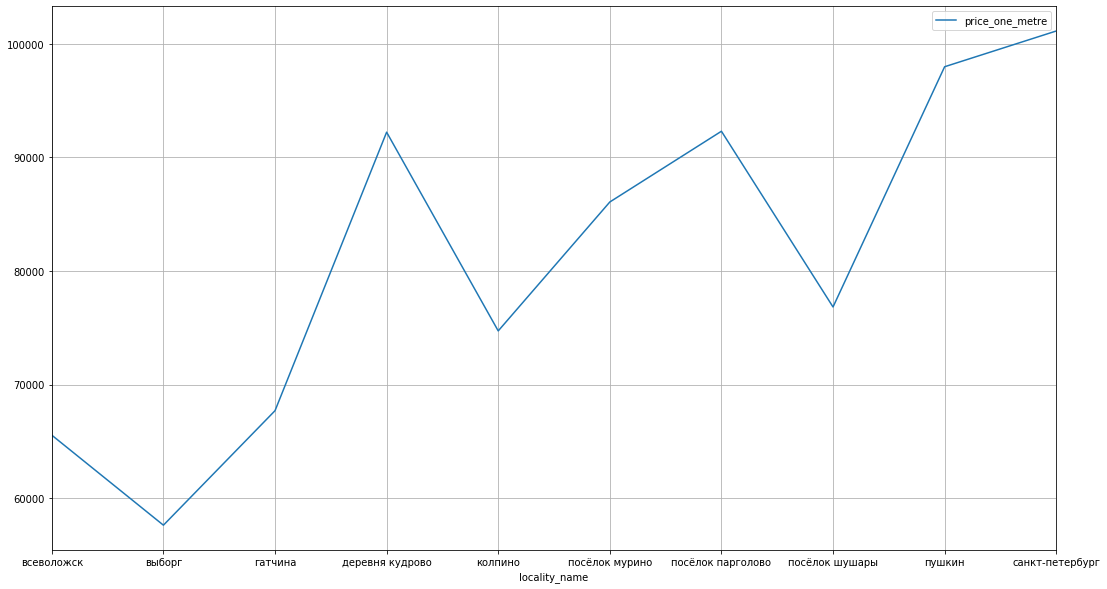

In [74]:
most_pop_local_piv_tab.plot(figsize = (18,10), grid = True);

<b> Вывод: </b> из 10 населённых пунктов с самым большим кол-вом объявлений, средняя цена за кв. метр оказалась самой высокой  в Санкт-Петербурге: она составила 101052, а самая низкая цена в Выборге - 58233, разница между самым дорогим и самым дешёвым метром в 1.735 раз.

<h3> Изучение предложения квартир в Санкт-Петербурге: </h3>

In [75]:
flats_spb = flats.query(' locality_name == "санкт-петербург" ')

In [76]:
# Напишем функцию, округляющую значение расстояния до целых чисел
def cityCent_nearest_km(row):
    return round(row['cityCenters_nearest']/1000)
flats_spb['cityCenters_nearest_km'] = flats.apply(cityCent_nearest_km, axis =1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [77]:
price_spb_pivot_table = flats_spb.groupby('cityCenters_nearest_km')[['price_one_metre']].mean()

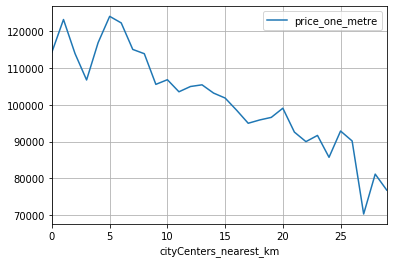

In [78]:
price_spb_pivot_table.plot( grid = True);

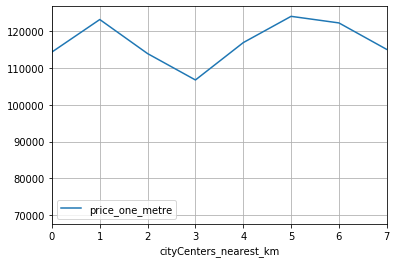

In [79]:
price_spb_pivot_table.plot( grid = True, xlim = (0,7));

<b> Вывод: </b> судя по графику, после 5-го км от центра график преимущественно только убывает, поэтому это и будем считать центром.

<h3> Выдение сегмента квартир в центре </h3>

In [80]:
flats_spb_center = flats_spb[ flats_spb['cityCenters_nearest_km'] < 5]

Изучим след. параметры: площадь, цена, число комнат, высота потолков

In [81]:
def chart_spb_center(atribut):
    pivot_tab = flats_spb_center.groupby(atribut)[['last_price']].median()
    pivot_tab.plot(grid = True);

In [82]:
def information_spb_center (atribut):
    print('Основная информация об атрибуте "{}":'.format(atribut))
    print(flats_spb_center[atribut].describe());

Основная информация об атрибуте "total_area":
count    501.000000
mean      61.490798
std       18.862021
min       12.000000
25%       47.000000
50%       61.500000
75%       73.000000
max      105.200000
Name: total_area, dtype: float64


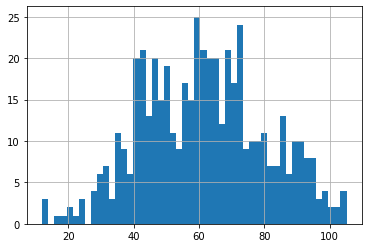

In [83]:
information_spb_center('total_area')
flats_spb_center['total_area'].hist(bins=50);

Медиана почти равна среднему, что говорит о том, что квартир с площадью больше чем средняя почти столько же, что и квартир с площадью меньше чем средняя., что интересно, самих квартир со средней площадью не так и много.

Основная информация об атрибуте "last_price":
count    5.010000e+02
mean     6.763642e+06
std      1.768008e+06
min      1.600000e+06
25%      5.400000e+06
50%      6.800000e+06
75%      8.200000e+06
max      1.003000e+07
Name: last_price, dtype: float64


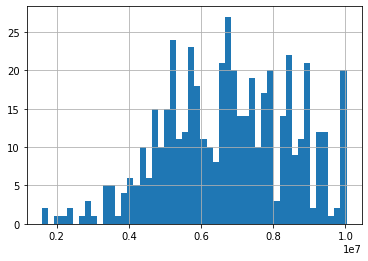

In [84]:
information_spb_center('last_price')
flats_spb_center['last_price'].hist(bins = 50);

График смещён в право, что говорит о том, что более дорогих квартир в центре намного больше чем дешёвых

Основная информация об атрибуте "rooms":
count    501.000000
mean       2.289421
std        0.902257
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: rooms, dtype: float64


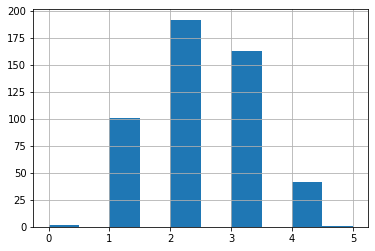

In [85]:
information_spb_center('rooms')
flats_spb_center['rooms'].hist();

В центре практически нет безкомнатных студий, больше всего 2-х комнатных, затем 3-х и 1-комнатных квартир.

Основная информация об атрибуте "ceiling_height":
count    501.000000
mean       2.760599
std        0.162055
min        2.500000
25%        2.640000
50%        2.750000
75%        2.880000
max        3.060000
Name: ceiling_height, dtype: float64


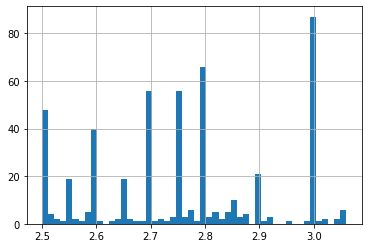

In [86]:
information_spb_center('ceiling_height')
flats_spb_center['ceiling_height'].hist(bins=50);

В центре потолков в 3м больше всего, также часто встречаются и другие высоты, влоть до 2.5 метров, такие пики на графиках говорят о том, что полотки имеют нормированную высоту, то есть часто имеют какие-то постоянные значения, и совсем редко от них отличаются.

Сравним параметры квартир из Спб в центре и по городу.

In [87]:
def center_comparison(atribut):
    pivot_tab_spb = flats_spb.groupby(atribut)[['last_price']].median()
    pivot_tab_spb_center = flats_spb_center.groupby(atribut)[['last_price']].median()
    ax = pivot_tab_spb.plot(grid = True, label = '33');
    pivot_tab_spb_center.plot(grid = True, ax = ax, label = '333');
    ax.legend()

In [88]:
def center_comparison(atribut):
    pivot_tab_spb = flats_spb.groupby(atribut)[['last_price']].median()
    pivot_tab_spb_center = flats_spb_center.groupby(atribut)[['last_price']].median()
    
    fig, ax = plt.subplots()
    
    ax.plot(pivot_tab_spb, label = 'price in the city')
    ax.plot(pivot_tab_spb_center, label = 'price in centre')
    
    ax.legend()

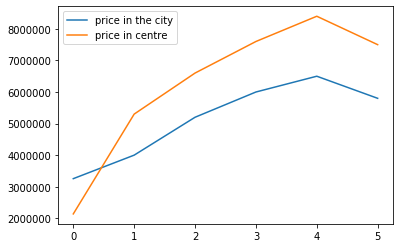

In [89]:
center_comparison('rooms')

Цена в центре здесь и в последующих графиках, очевидно, будет выше и это далее я повторять не буду, но что интересно в этом графике, студии в центре стоят дешевле чем в среднем по городу, между студией и однухой в центре разница примерно в 2.5 раза, дальше цена растёт пропорционально кол-ву комнат, как и в среднем по городу.

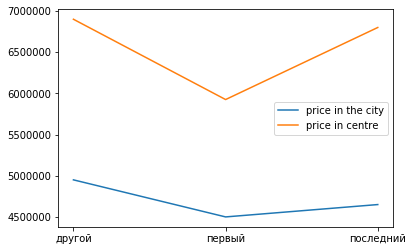

In [90]:
center_comparison('relative_floor')

В центре последний этаж ценится намного больше, чем в среднем по городу, но первый этаж относительно других ценится намного меньше, меньше чем в среднем по городу.

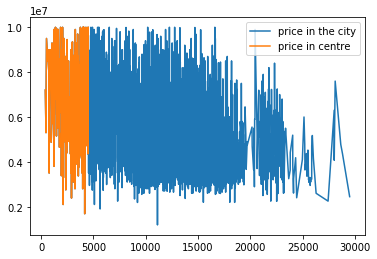

In [91]:
center_comparison('cityCenters_nearest')

График удалённости от центра по всему городу является логичным продолжением графика удалённости от центра по квартирам в центре. начиная с 25км от центра предложения встречаются реже, график выглядит жиже. 

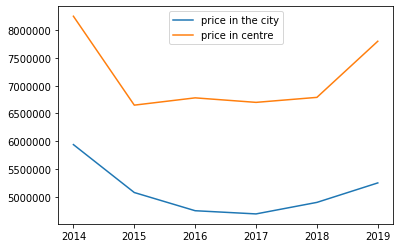

In [92]:
center_comparison('year_exposition')

В 14-м году объявлений о квартирах в центре не оказалось, но заметно, что в отличии от остального города, где 2016-2017 году квартиры не дорожали, в центре сразу начали дорожать, после падения за 2015.

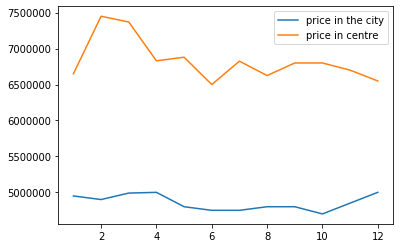

In [93]:
center_comparison('month_exposition')

В центре в декабре продаются самые дорогие квартиры, в то время, как в среднем по городу - самые дешёвые, также в декабре цена на квартиры в центре - минимальна, а в среднем по городу, наоборот - максимальна.

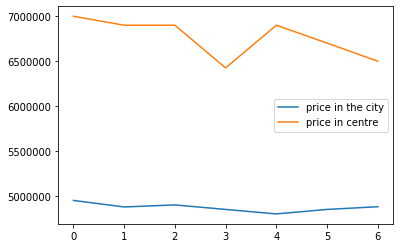

In [94]:
center_comparison('weekday_exposition')

В среднем по городу цена на квартиры практически не зависит от дня недели публикации, в то время, как в центре имеются сильные перепады графиков всю неделю.

Изучим таблицу корреляция для квартир в центре Спб.

In [95]:
flats_spb_center.corr()['last_price'].sort_values()

relation_kit_total       -0.379194
studio                   -0.116159
open_plan                -0.106228
cityCenters_nearest_km   -0.095309
month_exposition         -0.086624
cityCenters_nearest      -0.083013
ponds_around3000         -0.070891
parks_nearest            -0.065447
weekday_exposition       -0.054483
balcony                   0.018615
relation_liv_total        0.024000
floors_total              0.037381
year_exposition           0.048343
total_images              0.052548
days_exposition           0.079584
ponds_nearest             0.084176
parks_around3000          0.098901
floor                     0.121171
price_one_metre           0.128882
airports_nearest          0.141457
ceiling_height            0.257106
kitchen_area              0.389948
rooms                     0.525295
living_area               0.626705
total_area                0.708667
last_price                1.000000
is_apartment                   NaN
Name: last_price, dtype: float64

В центре цена сильно зависит от площади (общей, площади кухни, жилой площади), количества комнат, меньше от этажа и высоты потолков, отрицательная корреляция цены проявляется в относительной площади кухни, количества прудов рядом, а также является ли квартира студией и имеет ли свободную планировку. Апартаментов в центре нету.

<b> Вывод:</b> мы вывели сегмент квартир в центре, проанализировали их показатели, затем сравнили цену от числа комнат, этажа, удалённости от центра и даты размещения для квартир в Санкт-Петербурге и для квартир только в центре этого города. 

### Шаг 5. Общий вывод

<li> Мы открыли файл, разделили его методом sep на столбцы, изучили информацию и обнаружили в ней очень много разных пропусков и неправильных типов данных, мы заполнили пропуски в балконах и в is_apartment из логических соображений нулями, оставшиеся атрибуты заполнили медианным значением по группе, где это возможно и просто медианным, где это невозможно;
<li> Изменили вещественный тип данных в этажности дома, количестве балконов, водоёмов и парков поблизости на целочисленный, привели is_apartment к булевскому типу и изменили дату публикации на временной тип;
<li> Посчитали и добавили в таблицу: цену кв. метра, день недели, месяц и год публикации, этаж относительно дома (1-й/последний/другой) и отношение жилой и кухонной площади к общей;
<li> Изучили площадь, цену, число комнат и высоту потолков: графики оказались идентичными, с пиком на средних значениях, выпадающим минимумом и длинным хвостом до огромного максимума;
<li> Изучили время продажи кваартиры, узнали, что в среднем квартира продаётся за полгода - 250 дней, иногда продажи осуществлялись очень быстро - в течение месяце, а иногда время доходило до 5 лет;
<li> Для более точного дальнейшего анализа мы избавились от выделяюшихся значений, большинство из которых мы хапреметили, когда изучали параметры;
<li> Изучили зависимость цены от разных параметров, представив информацию и графики, помимо очевидных зависимостей от площади и кол-ва комнат, узнали, что цена падала с 14-го по 17-й год, а затем вновь пошла в рост, а также что у объявлений, выложенных в пятницу, средняя цена на квартиру наименьшая, а в пн. - наибольшая, в апреле наибольшая, а в мае - наименьшая, также узнали о том, как влияет этаж на цену: первый этаж ценится меньше всего, немного больше последний, квартиры на других этажах стоят значительно дороже;
<li> Выберали 10 населённых пунктов с наибольшим числом объявлений, посчитали для них цену квадратного метра и определили, что средняя цена за кв.м. максимальная в Спб. и составляет 100к, минимальная - в Выборге с 58т.руб/кв.м., разница между ними составила 1.73 раза;
<li> Для Санкт-Петербурга округлили расстояние до центра до целых чисел и определили по графику цены от расстояния до центр, когда график начинает убывать, так мы определили центральную зону, она оказалась радиусом 6км.
<li> Для Санкт-Петербурга сравнили зависимость цены от параметров в центре и в среднем по городу, где-то графики не сильно изменялись (month_exposition), где-то графики имели противоположные изменения (weekday_exposition, year_exposition), остальные графики повторяли рост и падения друг друга, только с разными угловыми коэффициентами